# Previously, on WHAT THE FUCK
In `2022-06-28-injection-and-recovery.ipynb` we used a fuck-tonne of simulations to do an injection and recovery test. It failed, except for primary mass, which was OK. Now we're going to reduce the 'data' dimensionality from `(b_mag, g_mag, r_mag)` to,... *drum roll please* `(b_mag - r_mag, g_mag)` and see if that cures all our ailments.

In [ ]:
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial#:~:text=when%20using%20matplotlib%3A-,Error%20%2315%3A%20Initializing%20libiomp5.,performance%20or%20cause%20incorrect%20results.
#import os
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
with open("isochrone_grid.pkl", "rb") as fp:
    data = pickle.load(fp)
    
isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs, [isochrone_bs, isochrone_gs, isochrone_rs] = data
isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs = list(map(np.array, (isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs)))
isochrone_bs, isochrone_gs, isochrone_rs = list(map(np.array, [isochrone_bs, isochrone_gs, isochrone_rs]))

Text(0, 0.5, 'Age')

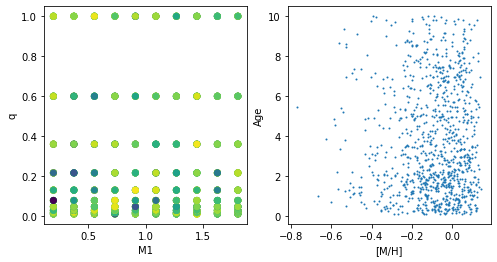

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(
    isochrone_m1s, 
    isochrone_qs,
    c=isochrone_fehs
)
axes[0].set_xlabel("M1")
axes[0].set_ylabel("q")
axes[1].scatter(
    isochrone_fehs,
    isochrone_ages,
    s=1,
)
axes[1].set_xlabel("[M/H]")
axes[1].set_ylabel("Age")

In [5]:
import torch
import numpy as np
from isochrones import get_ichrone

tracks = get_ichrone('mist', tracks=True)

def binary_color_mag_isochrones(
    m1,  # [Solar mass]
    q,   # m2/m1
    age, # [Gyr] 
    fe_h
):
    properties = tracks.generate_binary(
        m1,
        q * m1, 
        np.log10(age) + 9,  
        fe_h,
        bands=["G", "BP", "RP"]
    )
    b_mag = properties.BP_mag.values
    g_mag = properties.G_mag.values
    r_mag = properties.RP_mag.values
    #return np.array([b_mag, g_mag, r_mag]).T[0]
    return np.array([b_mag - r_mag, g_mag]).T[0]


Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [6]:

# Following https://www.mackelab.org/sbi/tutorial/00_getting_started/

from sbi import utils
from sbi import analysis
from sbi.inference.base import infer

print(f"Setting prior")
method = "SNPE"
labels = ("M1", "q", "age", "[M/H]")
bounds = torch.tensor([
    [0.1,  1.8], # M1
    [0.0,    1], # q
    [0.1,   10], # age (Gyr)
    [-1,   0.5]  # metallicity
])
photometric_uncertainty_scale = 1e-4

num_simulations = 10_000

prior = utils.BoxUniform(low=bounds.T[0], high=bounds.T[1])

print(f"Emulating posterior")
def simulator(theta):
    z = torch.tensor(binary_color_mag_isochrones(*theta))
    return z + torch.randn(z.shape) * photometric_uncertainty_scale

Setting prior
Emulating posterior


In [7]:
posterior = infer(
    simulator, 
    prior, 
    method=method, 
    num_simulations=num_simulations
)

Running 10000 simulations.: 100%|████████████████████████████████████████████████████████| 10000/10000 [00:58<00:00, 171.86it/s]


 Neural network successfully converged after 256 epochs.

In [11]:
num_samples = 10_000
num_tests = len(isochrone_m1s)
num_parameters = len(labels)
percentiles = [16, 50, 84]

all_samples = np.nan * np.ones((num_tests, num_samples, num_parameters))
all_percentiles = np.nan * np.ones((num_tests, num_parameters, len(percentiles)))
all_truths = np.vstack([isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs]).T
all_observations = np.vstack([isochrone_bs - isochrone_rs, isochrone_gs]).T

print(all_samples.shape)
print(all_percentiles.shape)
print(all_truths.shape)
print(all_observations.shape)

(1000, 10000, 4)
(1000, 4, 3)
(1000, 4)
(1000, 2)


In [13]:
from tqdm import tqdm

for i, observation in enumerate(tqdm(all_observations)):
    if not np.all(np.isfinite(observation)):
        continue
        
    samples = posterior.sample(
        (num_samples,), 
        x=torch.tensor(observation),
        show_progress_bars=False
    )
    all_samples[i] = np.array(samples)
    all_percentiles[i] = np.percentile(samples, percentiles, axis=0).T

100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.16it/s]


In [14]:
print(all_percentiles.shape)
print(all_truths.shape)

(1000, 4, 3)
(1000, 4)


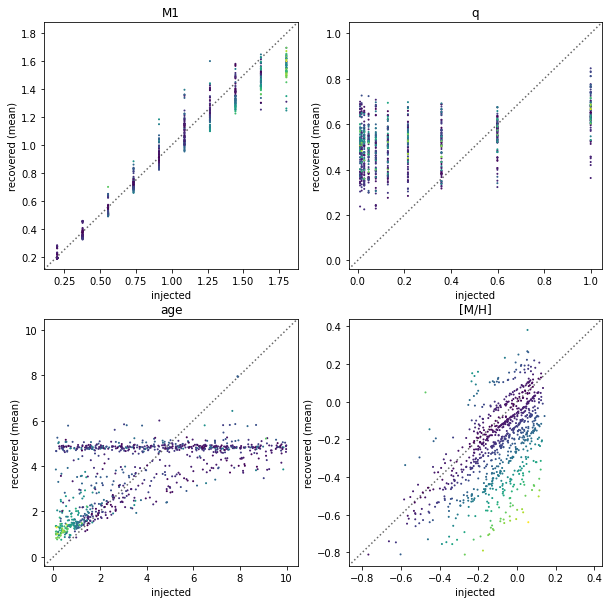

In [19]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
color_index = 3
for i, ax in enumerate(axes.flat):
    ax.scatter(
        all_truths[:, i],
        all_percentiles[:, i, 1],
        s=1,
        c=np.abs(all_truths[:, color_index] - all_percentiles[:, color_index, 1])
    )
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", zorder=-1, ls=":")
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_title(labels[i])
    ax.set_xlabel(r"injected")
    ax.set_ylabel(r"recovered (mean)")

# Well, that was a whole waste of time. Good thing I didn't use that many simulations!
All I learned here is that we can make-do with just (bp-rp, Gmag), and we can make do with just 10,000 simulations. I guess that was worth knowing.

In [21]:
# OK, can we try something dumb and re-parameterize as (M1, M2)?

In [22]:
def binary_color_mag_isochrones(
    m1,  # [Solar mass]
    m2,   
    age, # [Gyr] 
    fe_h
):
    properties = tracks.generate_binary(
        m1,
        m2, 
        np.log10(age) + 9,  
        fe_h,
        bands=["G", "BP", "RP"]
    )
    b_mag = properties.BP_mag.values
    g_mag = properties.G_mag.values
    r_mag = properties.RP_mag.values
    return np.array([b_mag - r_mag, g_mag]).T[0]

In [23]:
binary_color_mag_isochrones(1, 1.5, 4.5, 0)

array([0.77269182, 4.55370464])

In [24]:
print(f"Setting prior")
method = "SNPE"
labels = ("M1", "M2", "age", "[M/H]")
bounds = torch.tensor([
    [0.1,  1.8], # M1
    [0.1,  1.8], # M2
    [0.1,   10], # age (Gyr)
    [-1,   0.5]  # metallicity
])
photometric_uncertainty_scale = 1e-4

num_simulations = 10_000

prior = utils.BoxUniform(low=bounds.T[0], high=bounds.T[1])

print(f"Emulating posterior")
def simulator(theta):
    z = torch.tensor(binary_color_mag_isochrones(*theta))
    return z + torch.randn(z.shape) * photometric_uncertainty_scale

Setting prior
Emulating posterior


In [25]:
posterior = infer(
    simulator, 
    prior, 
    method=method, 
    num_simulations=num_simulations
)

Running 10000 simulations.: 100%|████████████████████████████████████████████████████████| 10000/10000 [01:01<00:00, 163.25it/s]


 Neural network successfully converged after 311 epochs.

In [26]:
labels = ("M1", "M2", "age", "[M/H]")

num_samples = 10_000
num_tests = len(isochrone_m1s)
num_parameters = len(labels)
percentiles = [16, 50, 84]

all_samples = np.nan * np.ones((num_tests, num_samples, num_parameters))
all_percentiles = np.nan * np.ones((num_tests, num_parameters, len(percentiles)))
all_truths = np.vstack([isochrone_m1s, isochrone_qs * isochrone_m1s, isochrone_ages, isochrone_fehs]).T
all_observations = np.vstack([isochrone_bs - isochrone_rs, isochrone_gs]).T

print(all_samples.shape)
print(all_percentiles.shape)
print(all_truths.shape)
print(all_observations.shape)


(1000, 10000, 4)
(1000, 4, 3)
(1000, 4)
(1000, 2)


In [27]:
for i, observation in enumerate(tqdm(all_observations)):
    if not np.all(np.isfinite(observation)):
        continue
        
    samples = posterior.sample(
        (num_samples,), 
        x=torch.tensor(observation),
        show_progress_bars=False
    )
    all_samples[i] = np.array(samples)
    all_percentiles[i] = np.percentile(samples, percentiles, axis=0).T

100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:35<00:00, 10.42it/s]


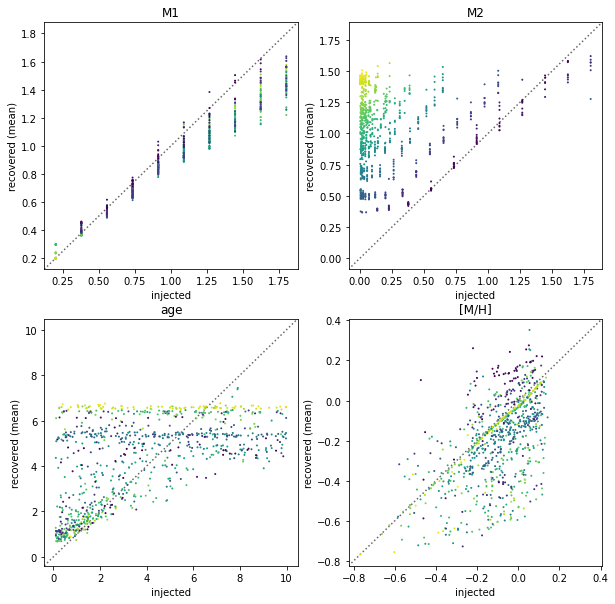

In [30]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
color_index = 1
for i, ax in enumerate(axes.flat):
    ax.scatter(
        all_truths[:, i],
        all_percentiles[:, i, 1],
        s=1,
        c=np.abs(all_truths[:, color_index] - all_percentiles[:, color_index, 1])
    )
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", zorder=-1, ls=":")
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_title(labels[i])
    ax.set_xlabel(r"injected")
    ax.set_ylabel(r"recovered (mean)")

In [ ]:
# OK, reparameterising as M1, M2 did no better (as expected, but good to test).


In [ ]:
# For my next trick (illusion), I will use a different inference method!
